In [ ]:
Шаг 1. Парсим ИНН и Айдишники с 'https://rmsp.nalog.ru/search-proc.json' 
Затем парсим GainSum Для Шага 3 через 'https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0'
Можно указать количество ИНН больше (total_records) и тогда выборка будет больше, но и обработка данных будет занимать больше времени

In [ ]:
import requests
import json
import time
from collections import defaultdict

# Данные для POST-запроса
form_data = {
    'dtCategory': '10.01.2025',
    'okved1': '41.2',
    'pageSize': '100',  # Количество записей на странице
    'mode': 'extended',
    'query': '',
    'nptype': "UL",
    'is_pp': 1,
    'category': 2
}

inn_list = []
total_records = 500  # Необходимое количество записей (ИНН)
records_fetched = 0
page = 1

# Шаг 1: Сбор ИНН
while records_fetched < total_records:
    form_data["page"] = page

    response = requests.post('https://rmsp.nalog.ru/search-proc.json', data=form_data)
    
    try:
        response.raise_for_status()
        data = response.json()
    except (requests.exceptions.RequestException, ValueError) as e:
        print(f"Ошибка при запросе страницы {page}: {e}")
        break

    if 'data' in data:
        records = data['data']
        
        if not records:
            print(f"Записи не найдены на странице {page}.")
            break

        for record in records:
            inn = record.get('inn')
            if inn and inn not in inn_list:
                inn_list.append(inn)
        
        records_fetched = len(inn_list)  # Учитываем только уникальные INN
        print(f"Получено записей с уникальными ИНН: {records_fetched} (страница {page}).")
        page += 1
    else:
        print(f"Ошибка данных на странице {page}.")
        break

print("\nСписок уникальных INN:")
print(inn_list)
print(f"Общее количество уникальных INN: {len(inn_list)}")

# Шаг 2: Сбор данных для каждого INN
all_parsed_data = defaultdict(list)
id_data = defaultdict(list)

for inn in inn_list:
    url = f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0"
    headers = {'User-Agent': 'Mozilla/5.0 ...'}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
    except (requests.exceptions.RequestException, ValueError) as e:
        print(f"Ошибка запроса для INN {inn}: {e}")
        continue

    # Проверяем, есть ли данные
    for item in data.get('content', []):
        company_id = item.get('id')  # Получение id компании
        bfo_list = item.get('bfo', [])

        # Сохранение ID компаний с учетом множественного результата для одного INN
        if company_id and company_id not in id_data[inn]:
            id_data[inn].append(company_id)

        # Сохраняем данные о периодах и доходах
        for bfo in bfo_list:
            period = bfo.get('period')
            gain_sum = bfo.get('gainSum')
            if period and gain_sum:
                all_parsed_data[inn].append({'period': period, 'gain_sum': gain_sum})

    print(f"Данные успешно собраны для INN: {inn}")
    time.sleep(0.1)  # Задержка между запросами

# Шаг 3: Сохранение данных
with open('parsed_data.json', 'w', encoding='utf-8') as f:
    json.dump(all_parsed_data, f, ensure_ascii=False, indent=4)

with open('ids_data.json', 'w', encoding='utf-8') as f:
    json.dump(id_data, f, ensure_ascii=False, indent=4)

print("\nВсе данные успешно сохранены в parsed_data.json и ids_data.json")


In [ ]:
Шаг 2. Считаем EBITDA для компаний за 2023 год, собрав необходимую информацию с сайта https://bo.nalog.ru/nbo/organizations/{company_id}/bfo/

In [21]:
import json
import requests
import time

# Загрузка ID из файла
with open('ids_data.json', 'r', encoding='utf-8') as f:
    id_data = json.load(f)

ebitda_data = {}

# Перебираем ИНН и соответствующие им списки ID компаний
for inn, company_ids in id_data.items():
    for company_id in company_ids:  # Проходим по каждому ID в списке
        url = f"https://bo.nalog.ru/nbo/organizations/{company_id}/bfo/"
        headers = {'User-Agent': 'Mozilla/5.0 ...'}

        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()

            financial_reports = response.json()

            ebitda_calculated = False
            for report in financial_reports:
                if report.get('period') == "2023":
                    correction = report.get('correction', {})
                    financial_result = correction.get('financialResult', {})

                    current2110 = financial_result.get('current2110')
                    current2120 = financial_result.get('current2120')

                    if current2110 is not None and current2120 is not None:
                        try:
                            ebitda = ((current2110 - current2120) * 100) / current2110
                            ebitda_data[company_id] = ebitda
                            ebitda_calculated = True
                            print(f"EBITDA для компании с ID {company_id} за 2023 год: {ebitda:.2f}")
                            break
                        except ZeroDivisionError:
                            print(f"Выручка равна 0 для компании с ID {company_id}. Невозможно посчитать EBITDA.")

            if not ebitda_calculated:
                print(f"Нет финансовой отчетности за 2023 год для компании с ID {company_id}.")

        except requests.exceptions.Timeout:
            print(f"Запрос к компании с ID {company_id} превысил время ожидания.")
        except requests.exceptions.RequestException as e:
            print(f"Ошибка запроса для ID {company_id}: {e}")

        time.sleep(0.1)

# Сохранение вычисленных данных EBITDA
with open('ebitda_data.json', 'w', encoding='utf-8') as f:
    json.dump(ebitda_data, f, ensure_ascii=False, indent=4)

print("Все данные EBITDA успешно сохранены в ebitda_data.json")


EBITDA для компании с ID 5872486 за 2023 год: 16.95
EBITDA для компании с ID 5972153 за 2023 год: 13.69
EBITDA для компании с ID 2341048 за 2023 год: 1.87
EBITDA для компании с ID 2996748 за 2023 год: 13.46
EBITDA для компании с ID 4980670 за 2023 год: 8.53
EBITDA для компании с ID 3867230 за 2023 год: 7.53
EBITDA для компании с ID 7041303 за 2023 год: 0.99
EBITDA для компании с ID 6840082 за 2023 год: 19.17
EBITDA для компании с ID 5446585 за 2023 год: 20.63
EBITDA для компании с ID 7244164 за 2023 год: 1.90
EBITDA для компании с ID 2608351 за 2023 год: 16.95
EBITDA для компании с ID 4659067 за 2023 год: 175.40
EBITDA для компании с ID 5591507 за 2023 год: 2.95
EBITDA для компании с ID 1410906 за 2023 год: -5.26
EBITDA для компании с ID 12154616 за 2023 год: 9.64
EBITDA для компании с ID 5028116 за 2023 год: 20.27
EBITDA для компании с ID 91738 за 2023 год: 28.62
EBITDA для компании с ID 6320206 за 2023 год: 3.38
EBITDA для компании с ID 611402 за 2023 год: 67.92
EBITDA для компании с

In [ ]:
Шаг 3. Строим графики распределения роста чистой прибыли компаний

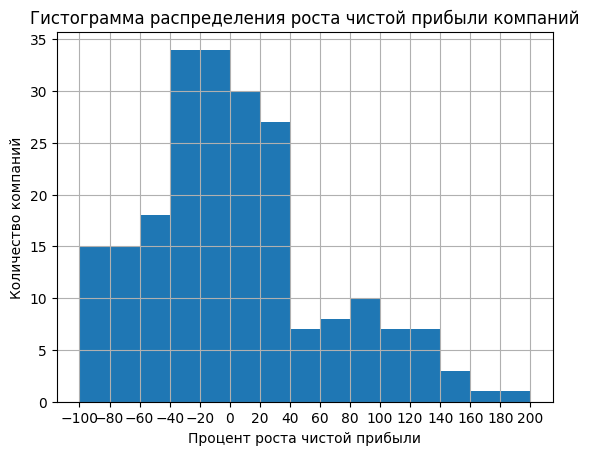

Вывод: Из графика видно, как распределяется рост чистой прибыли среди компаний за последние два года. Большинство компаний демонстрируют умеренный рост или стагнацию, однако, есть как аномально успешные, так и компании с негативным ростом.


In [22]:
# Загрузка обработанных данных
with open('parsed_data.json', 'r', encoding='utf-8') as f:
    all_parsed_data = json.load(f)

growth_rates = []

# Расчет процента роста прибыли для каждой компании
for inn, records in all_parsed_data.items():
    if len(records) >= 2:
        records_sorted = sorted(records, key=lambda x: x['period'])
        try:
            recent_gain = float(records_sorted[-1]['gain_sum'])
            past_gain = float(records_sorted[-2]['gain_sum'])
            # Расчет роста
            growth = ((recent_gain - past_gain) / abs(past_gain)) * 100
            growth_rates.append(growth)
        except ValueError:
            # Пропускать записи с неправильными данными
            continue

# Группировка по процентному росту
binned_growth = [range(-100, 201, 20)]
bins = range(-100, 210, 20)
hist, bins = np.histogram(growth_rates, bins=bins)

plt.bar(bins[:-1], hist, width=20, align='edge')

plt.xlabel('Процент роста чистой прибыли')
plt.ylabel('Количество компаний')
plt.title('Гистограмма распределения роста чистой прибыли компаний')
plt.grid(True)

plt.xticks(range(-100, 210, 20))
plt.show()

# Вывод
print("Вывод: Из графика видно, как распределяется рост чистой прибыли среди компаний за последние два года. Большинство компаний демонстрируют умеренный рост или стагнацию, однако, есть как аномально успешные, так и компании с негативным ростом.")


In [ ]:
Шаг 4. Строим графики для отображения перспективности отрасли по EBITDA

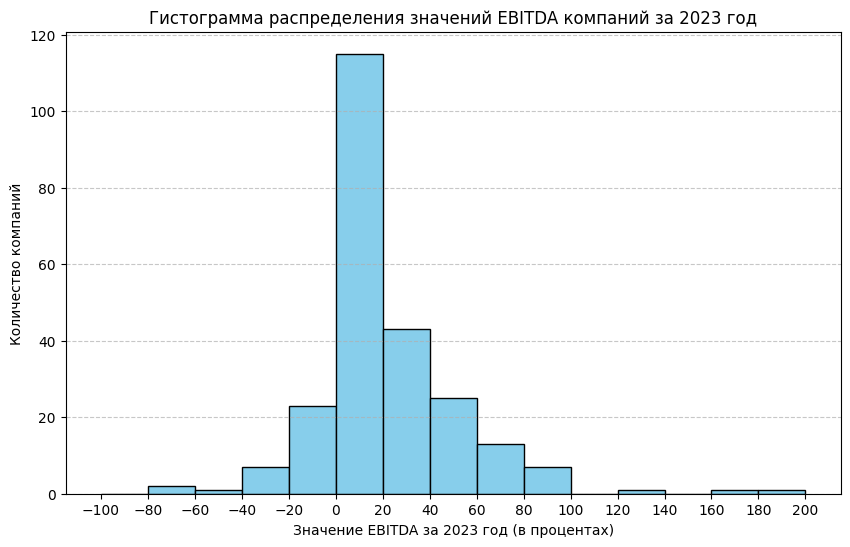


Вывод:
1. Большинство компаний имеют значения EBITDA в диапазоне от 0% до 40%, что показывает нормальный уровень прибыльности.
2. Некоторое количество компаний также имеет отрицательные значения EBITDA, что может указывать на проблемы с рентабельностью или высокие издержки.
3. Компании с EBITDA выше 100% - это пример высокой эффективности и прибыльности, но их количество значительно меньше.


In [26]:
# Загрузка данных EBITDA из файла
with open('ebitda_data.json', 'r', encoding='utf-8') as f:
    ebitda_data = json.load(f)

# Значения EBITDA
ebitda_values = list(ebitda_data.values())

# Группировка по процентному значению EBITDA
bins = range(-100, 220, 20)
hist, bins = np.histogram(ebitda_values, bins=bins)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=20, edgecolor='black', color='skyblue', align='edge')

plt.xlabel('Значение EBITDA за 2023 год (в процентах)')
plt.ylabel('Количество компаний')
plt.title('Гистограмма распределения значений EBITDA компаний за 2023 год')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Настройка меток оси X
plt.xticks(bins)

plt.show()

# Вывод
print("\nВывод:")
print("1. Большинство компаний имеют значения EBITDA в диапазоне от 0% до 40%, что показывает нормальный уровень прибыльности.")
print("2. Некоторое количество компаний также имеет отрицательные значения EBITDA, что может указывать на проблемы с рентабельностью или высокие издержки.")
print("3. Компании с EBITDA выше 100% - это пример высокой эффективности и прибыльности, но их количество значительно меньше.")